# Python functions to estimate completeness magnitudes and b-values for catalogues of seismicity

This notebook is intended to be a brief, time-saving guide to estimating completeness magnitudes and b-values in Python. Steps are briefly explained throughout but please check out accompanying citations for more detail. Much of the text throughout has been copied from my [PhD thesis](https://research-information.bris.ac.uk/en/studentTheses/detecting-and-characterising-seismicity-associated-with-volcanic-) (I have indicated when this is the case), so please be careful when re-using.

These functions are based on the R code in the Appendix of Mignan and Woessner's CORSSA article: http://www.corssa.org/export/sites/corssa/.galleries/articles-pdf/Mignan-Woessner-2012-CORSSA-Magnitude-of-completeness.pdf_2063069299.pdf

In [1]:
# Import packages
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

# Set plot size to be larger than default:
plt.rcParams["figure.figsize"] = (10,5)

## 1. Import some data

The following catalogue of seismicity is taken from **Lapins et al. (2021)** '*A Little Data Goes a Long Way: Automating Seismic Phase Arrival Picking at Nabro Volcano With Transfer Learning*' (https://doi.org/10.1029/2021JB021910). Please cite this paper when using any of this data. Please also feel free to contact me if you would like the full catalogue with event locations, error estimates, etc.

The catalogue was compiled using a machine learning phase arrival detection model (known as 'U-GPD'; see above paper) and subsequently analysed for my [PhD thesis](https://research-information.bris.ac.uk/en/studentTheses/detecting-and-characterising-seismicity-associated-with-volcanic-). An accompanying journal paper on its analysis is currently in prep.

In [2]:
# Read in some sample data
catalog = pd.read_pickle("./locs_s_all_mags.pkl")

In [3]:
catalog

,time,ml,mw
0,2011-08-30 00:14:46.809999872,1.051146,1.390547
1,2011-08-30 00:23:18.650000128,0.894163,1.253851
2,2011-08-30 01:10:54.500000000,1.452321,1.536594
3,2011-08-30 01:24:03.329999872,1.327316,1.582209
4,2011-08-30 01:37:44.240000000,1.284561,1.453335
...,...,...,...
33945,2012-09-30 22:01:04.190000128,0.672541,1.070721
33946,2012-09-30 22:22:26.809999872,0.871515,1.144748
33947,2012-09-30 22:34:02.000000000,0.906657,1.446747
33948,2012-09-30 23:12:03.309999872,0.573383,1.251899


This is a dataframe of event times and magnitudes. **ml** is local magnitude ($M_{L}$), **mw** is moment magnitude ($M_{W}$).

Local magnitudes were calculated using a local magnitude scale fitted directly to the data (see [my PhD thesis](https://research-information.bris.ac.uk/en/studentTheses/detecting-and-characterising-seismicity-associated-with-volcanic-); Chapters 5-6):

$$M_{L}=\log_{10}{(A)}-0.221266\log_{10}{(r/17)}+0.048369(r-17)+2\tag{1}$$

Amplitudes, $A$, are taken from both horizontal components and $M_{L}$ values are first estimated for each horizontal component at each station. Station-component corrections (from scale fitting procedure, see [thesis](https://research-information.bris.ac.uk/en/studentTheses/detecting-and-characterising-seismicity-associated-with-volcanic-) Chapter 6) are then applied and $M_{L}$ values at each station are averaged to get individual station estimates of $M_{L}$. Final event $M_{L}$ values in the above catalogue are the average of all available station $M_{L}$ values for an event.

Moment magnitudes ($M_{W}$) were calculated by first using an attenuation estimation method developed in [my PhD thesis](https://research-information.bris.ac.uk/en/studentTheses/detecting-and-characterising-seismicity-associated-with-volcanic-) (Chapters 5-6) to estimate $Q$, $\kappa_{0}$ and $R$ terms, and then by fitting a Brune model to estimate the low-frequency plateau of the event spectrum ($\Omega_{0}$).

## 2. Calculating the frequency-magnitude distribution (FMD)

(copied from my thesis:)

One of the most widely used statistical representations of earthquake magnitudes is the frequency-magnitude distribution (FMD) and its so-called 'b-value'. Above some magnitude of completeness ($M_{c}$), where the SNR is sufficiently high that all earthquakes of magnitude larger than or equal to this can be assumed recorded, the FMD can often be modelled by the Gutenberg-Richter (GR) relationship

$$\log_{10}{(n)}=a-bM\tag{2}$$

where $n$ is the total number of earthquakes of magnitude larger or equal to $M$, and $a$ and $b$ are real, positive constants. It can be seen from Eq $(2)$ that $a$ is the value of $\log_{10}{(n)}$ for $M=0$ (i.e., the logarithm of the number of earthquakes with magnitude larger or equal to 0), and therefore provides a measure of seismicity rate. The value of $b$ (known simply as the 'b-value' of a catalogue of earthquake magnitudes) represents the proportion of large to small earthquakes in the catalogue.

Below is a function to calculate the FMD.

In [4]:
# Frequency-magnitude distribution function (Mignan & Woessner article)

# mag: catalogue of magnitudes
# mbin: magnitude bin size

def fmd(mag, mbin):
    minmag = math.floor(min(mag/mbin)) * mbin # Lowest magnitude bin
    maxmag = math.ceil(max(mag/mbin)) * mbin # Highest magnitude bin
    mi = np.arange(minmag, maxmag + mbin, mbin) # Sequence of magnitude bins
    nbm = len(mi) # No. of magnitude bins
    cumnbmag = np.zeros(nbm) # Pre-allocate array for cumulative no. of events in mag bin and higher

    # Get cumulative no. of events in mag bin and higher
    for i in range(nbm):
        cumnbmag[i] = np.where(mag > mi[i] - mbin/2)[0].shape[0]
        
    # Get no. of events in each mag bin:
    nbmag = abs(np.diff(np.append(cumnbmag, 0)))
    
    return mi, nbmag, cumnbmag # Return magnitude bins, no. of events in bin, and cumulative no. of events

In [5]:
# Get FMD for moment magnitude (mw) estimates
cat_mi, cat_nbmag, cat_cumnbmag = fmd(mag = catalog['mw'], mbin = 0.1)

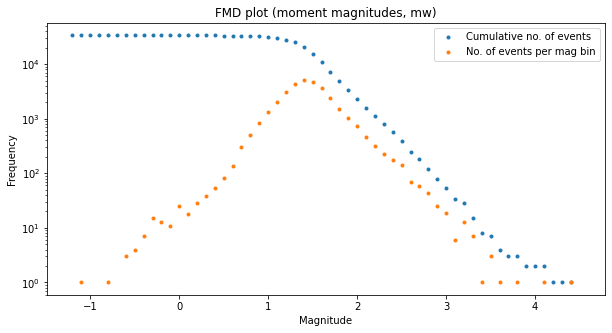

In [6]:
plt.plot(cat_mi, cat_cumnbmag, '.', label="Cumulative no. of events")
plt.plot(cat_mi, cat_nbmag, '.', label="No. of events per mag bin")
plt.yscale('log')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.title('FMD plot (moment magnitudes, mw)')
plt.legend(loc="upper right")
plt.show()

## 3. Estimating b-value (maximum likelihood)

(copied from my thesis:)

The most common and almost universally accepted approach for calculating the b-value of a catalogue is the maximum likelihood method (Aki, 1965; Bender, 1983). This method assumes that the data is exponentially distributed and that the maximum magnitude is at infinity. The latter is obviously not physically plausible, but it is generally assumed that the sample at hand is not large enough to sample the maximum possible magnitude for a region (Naylor et al 2010). The b-value can then be estimated by (Aki, 1965)

$$\hat{b} = \frac{\log_{10}{(e)}}{\bar{M} - (M_c - \Delta{M}/2)}\tag{3}$$

where $\bar{M}$ and $\hat{b}$ are mean magnitude and estimate of the b-value, respectively, above completeness magnitude $M_c$, and $\Delta{M}/2$ is a correction for finite binning width $\Delta{M}$ of the magnitude catalogue (Bender, 1983).

When formulated in this way, the uncertainty on $\hat{b}$ can be estimated by

$$\sigma{(\hat{b})}=\frac{\hat{b}}{\sqrt{n}}\tag{4}$$

where $\sigma{(\hat{b})}$ is the standard error corresponding to 1 standard deviation, or a 68% confidence interval (Aki, 1965). However, it has been demonstrated that a more reliable estimation of uncertainty in the presence of slow spatial or temporal changes in $b$ (Shi & Bolt, 1982; Marzocchi & Sandri 2003) can be estimated by 

$$\sigma{(\hat{b})}=2.3\hat{b}^{2}\sqrt{\frac{\sum_{i=1}^{N}(M_i-\bar{M})^2}{n(n-1)}}\tag{5}$$

where $M_i$ is the magnitude for event $i$ above completeness magnitude $M_c$.

The function below estimates b-value using Eq $(3)$ and outputs uncertainty in the forms of Eq $(4)$ and $(5)$. Eq $(5)$ is often considered more robust and thus preferred when providing uncertainty estimates, but both are generally accepted.

In [7]:
# Function to estimate b-value using maximum likelihood method (Aki, 1965), original Aki error estimate (Aki, 1965), and Shi & Bolt (1982) improved uncertainty estimate: 

# mag: catalogue of magnitudes
# mbin: magnitude bin size
# mc: completeness magnitude

def b_est(mag, mbin, mc):
    
    mag_above_mc = mag[np.where(mag > round(mc,1)-mbin/2)[0]].values # Magnitudes for events larger than cut-off magnitude mc
    n = mag_above_mc.shape[0] # No of. events larger than cut-off magnitude mc
    if n < 2:
        a = np.nan
        b = np.nan
        aki_unc = np.nan
        shibolt_unc = np.nan
    else:
        mbar = np.mean(mag_above_mc) # Mean magnitude for events larger than cut-off magnitude mc
        b = math.log10(math.exp(1)) / (mbar - (mc - mbin/2)) # b-value from Eq 3
        a = math.log10(n) + b * mc # 'a-value' for Eq 2
        aki_unc = b / math.sqrt(n) # Uncertainty estimate from Eq 4
        shibolt_unc = 2.3 * b**2 * math.sqrt(sum((mag_above_mc - mbar)**2) / (n * (n-1))) # Uncertainty estimate from Eq 5

    return a, b, aki_unc, shibolt_unc # Return b-value and estimates of uncertainty

Let's compare b-value estimates for two different choices of completeness magnitude ($M_{c} = 2$ and $M_{c} = 1$) 

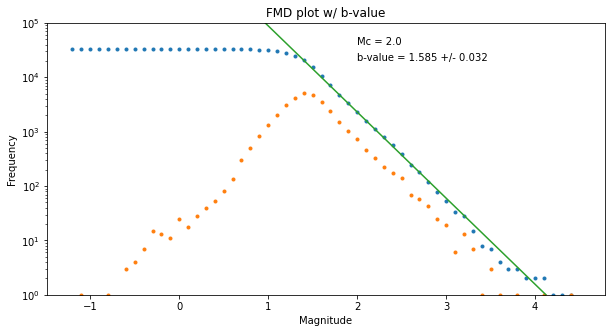

In [8]:
# Plot b-value estimate for a completeness magnitude of 2.0

cat_mc = 2.0 # Completeness magnitude
cat_a, cat_b, cat_aki_unc, cat_shibolt_unc = b_est(mag = catalog['mw'], mbin = 0.1, mc = cat_mc)

plt.plot(cat_mi, cat_cumnbmag, '.')
plt.plot(cat_mi, cat_nbmag, '.')
plt.plot(cat_mi, (10**(cat_a - (cat_b * cat_mi))))

plt.yscale('log')
plt.ylim(1, 10**math.ceil(math.log10(catalog.shape[0])))
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.title('FMD plot w/ b-value')
plt.text(x=2, y=4e4, s="Mc = " + str(round(cat_mc, 1)))
plt.text(x=2, y=2e4, s="b-value = " + str(round(cat_b, 3)) + " +/- " + str(round(cat_shibolt_unc, 3)))
plt.show()

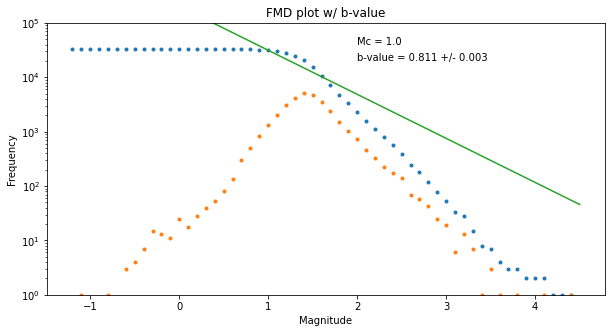

In [9]:
# Plot b-value estimate for a completeness magnitude of 1.0.

cat_mc = 1.0 # Completeness magnitude
cat_a, cat_b, cat_aki_unc, cat_shibolt_unc = b_est(mag = catalog['mw'], mbin = 0.1, mc = cat_mc)

plt.plot(cat_mi, cat_cumnbmag, '.')
plt.plot(cat_mi, cat_nbmag, '.')
plt.plot(cat_mi, (10**(cat_a - (cat_b * cat_mi))))

plt.yscale('log')
plt.ylim(1, 10**math.ceil(math.log10(catalog.shape[0])))
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.title('FMD plot w/ b-value')
plt.text(x=2, y=4e4, s="Mc = " + str(round(cat_mc, 1)))
plt.text(x=2, y=2e4, s="b-value = " + str(round(cat_b, 3)) + " +/- " + str(round(cat_shibolt_unc, 3)))
plt.show()

As you can see, the b-value estimate is pretty sensitive to choice of completeness magnitude, with $M_{c} = 2$ giving a high b-value of 1.585 and $M_{c} = 1$ giving a low b-value of 0.811. Plotting the b-value for $M_{c} = 2$ also looks like a better fit to the eye. These two values, 1 and 2, were chosen arbitrarily. I will now show you some methods for properly estimating completeness magnitude.

## 4. Estimating completeness magnitude

(taken from thesis again:)

Three of the most commonly used approaches for determining $M_c$ are the Maximum Curvature (MAXC) method (Weimer and Wyss, 2000), the goodness-of-fit test (GFT; Weimer & Wyss, 2000) and the $M_c$ by b-value stability (MBS) method (Cao and Gao, 2002). 

#### 4.1 MAXC

The MAXC (Weimer and Wyss, 2000) method is the most straightforward approach, simply using the magnitude bin from the non-cumulative FMD (orange dots in figures above) containing the highest frequency of events (i.e., the peak of the orange dots). However, this approach has the highest potential to underestimate $M_c$ when detection rates vary (e.g., due to changing station availability) and will usually give the lowest estimate of all methods (Mignan & Woessner, 2012).

In [10]:
# Function to get completeness magnitude with MAXC method

def get_maxc(mag, mbin):
    this_fmd = fmd(mag, mbin) # FMD
    maxc = this_fmd[0][np.argmax(this_fmd[1])] # Mag bin with highest no. of events
    return round(maxc, 1)

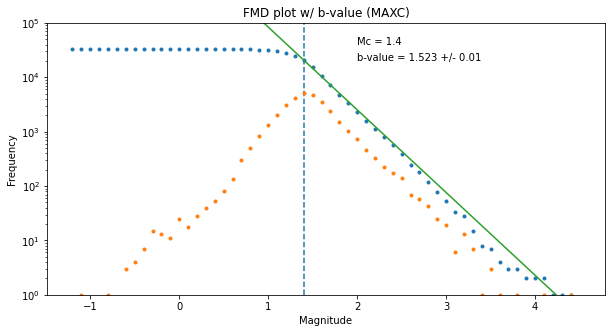

In [11]:
# Plot b-value estimate using MAXC to estimate complteness magnitude

cat_mc = get_maxc(mag = catalog['mw'], mbin = 0.1) # MAXC completeness magnitude
cat_a, cat_b, cat_aki_unc, cat_shibolt_unc = b_est(mag = catalog['mw'], mbin = 0.1, mc = cat_mc)

plt.plot(cat_mi, cat_cumnbmag, '.')
plt.plot(cat_mi, cat_nbmag, '.')
plt.plot(cat_mi, (10**(cat_a - (cat_b * cat_mi))))

plt.vlines(cat_mc, ymin=1, ymax=10**math.ceil(math.log10(catalog.shape[0])), linestyles='dashed')

plt.yscale('log')
plt.ylim(1, 10**math.ceil(math.log10(catalog.shape[0])))
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.title('FMD plot w/ b-value (MAXC)')
plt.text(x=2, y=4e4, s="Mc = " + str(round(cat_mc, 1)))
plt.text(x=2, y=2e4, s="b-value = " + str(round(cat_b, 3)) + " +/- " + str(round(cat_shibolt_unc, 3)))
plt.show()

#### 4.2 GFT

The GFT (Weimer & Wyss, 2000) estimates $M_c$ by comparing the observed FMD with synthetic GR distributions (i.e., synthetic distributions in the form of Eq $(2)$). The smallest cut-off magnitude $M_{co}$ with a residual between the observed and synthetic FMD below some threshold (typically 5% of the sum of observed cumulative number of events from each magnitude bin) is accepted as the final $M_c$. This residual is calculated using the absolute differences between the observed ($B_i$) and predicted ($S_i$) number of events in each magnitude bin, formulated by

$$R=\frac{\sum_{M_{co}}^{M_{max}}\lvert B_i - S_i \rvert}{\sum_i B_i}\times{100}\tag{6}$$

Although more conservative than the MAXC approach, the GFT still generally produces lower estimates of $M_c$ than other methods (Mignan & Woessner, 2012; Wiemer & Wyss, 2000) due to the criterion of using the lowest $M_{co}$  within an acceptable confidence level. From personal experimentation, it also appears to be much least stable when catalogue sizes are small.

In [12]:
# Function to get completeness magnitude with GFT method

def get_gft(mag, mbin):
    this_fmd = fmd(mag, mbin) # FMD
    this_maxc = get_maxc(mag, mbin) # Needed further down

    # Zeros to accommodate synthetic GR distributions for each magnitude bin
    a = np.zeros(this_fmd[0].shape[0]) # Pre-allocate array to accommodate a values from Eq 2
    b = np.zeros(this_fmd[0].shape[0]) # Pre-allocate array to accommodate b values from Eq 2 & 3
    R = np.zeros(this_fmd[0].shape[0]) # Pre-allocate array to accommodate R values from Eq 6

    # Loop through each magnitude bin, using it as cut-off magnitude
    for i in range(this_fmd[0].shape[0]):
        mi = round(this_fmd[0][i], 1) # Cut-off magnitude
        try:
            a[i], b[i], tmp1, tmp2 = b_est(mag, mbin, mi) # a and b-values for this cut-off magnitude
        except:
            continue
        synthetic_gr = 10**(a[i] - b[i]*this_fmd[0]) # Synthetic GR for a and b
        Bi = this_fmd[2][i:] # B_i in Eq 6
        Si = synthetic_gr[i:] # S_i in Eq 6
        R[i] = (sum(abs(Bi - Si)) / sum(Bi)) * 100 # Eq 6

    # Confidence levels to test
    R_to_test = [95, 90] # (95% and 90% conf levels)

    GFT_test = [np.where(R <= (100 - conf_level)) for conf_level in R_to_test] # Test whether R within confidence level
    # Loop through and check first cut-off mag within confidence level
    for i in range(len(R_to_test)+1):
        # If no GR distribution fits within confidence levels then use MAXC instead
        if i == (len(R_to_test) + 1):
            mc = this_maxc
            print("No fits within confidence levels, using MAXC estimate")
            break
        else:
            if len(GFT_test[i][0]) > 0:
                mc = round(this_fmd[0][GFT_test[i][0][0]], 1) # Use first cut-off magnitude within confidence level
                break
    
    return mc, this_fmd[0], R

/Users/sl15218/anaconda3/envs/obspy/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in less_equal


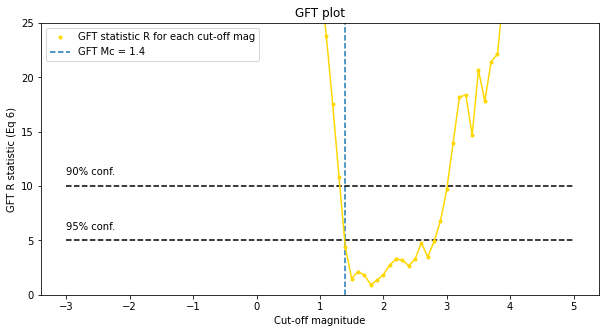

In [13]:
# Plot b-value estimates using GFT

# First, plot R goodness of fit statistic for each cut-off magnitude:
cat_gft = get_gft(mag = catalog['mw'], mbin = 0.1) # GFT completeness magnitude

plt.plot(cat_gft[1], cat_gft[2], '.', color="gold", label="GFT statistic R for each cut-off mag")
plt.plot(cat_gft[1], cat_gft[2], color="gold")

plt.vlines(cat_gft[0], ymin=0, ymax=100, linestyles='dashed', label="GFT Mc = " + str(round(cat_gft[0], 1)))
plt.hlines(5, xmin=-3, xmax=5, linestyles='dashed', colors='k')
plt.hlines(10, xmin=-3, xmax=5, linestyles='dashed', colors='k')
plt.text(x=-3, y=11, s="90% conf.")
plt.text(x=-3, y=6, s="95% conf.")
plt.ylim(0, 25)
plt.xlabel('Cut-off magnitude')
plt.ylabel('GFT R statistic (Eq 6)')
plt.title('GFT plot')
plt.legend(loc='upper left')
plt.show()

As you can see from the above plot, the GFT method uses the smallest cut-off magnitude $M_{co}$ that exceeds a given confidence level for $M_{c}$ (e.g., for 95% confidence level, use first $M_{co}$ that satisfies $100 - R \ge 95$ or $R \le 5$ as $M_{c}$).

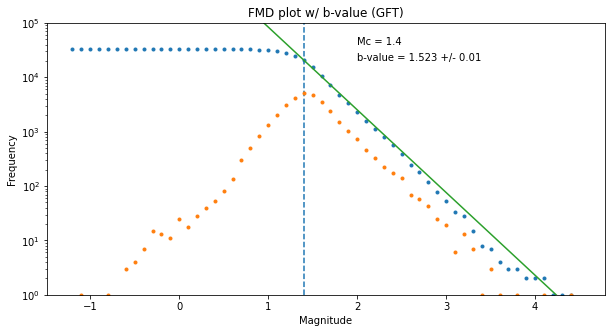

In [14]:
# Then plot GFT b-value against FMD

cat_mc = cat_gft[0] # GFT completeness magnitude
cat_a, cat_b, cat_aki_unc, cat_shibolt_unc = b_est(mag = catalog['mw'], mbin = 0.1, mc = cat_mc)

plt.plot(cat_mi, cat_cumnbmag, '.')
plt.plot(cat_mi, cat_nbmag, '.')
plt.plot(cat_mi, (10**(cat_a - (cat_b * cat_mi))))

plt.vlines(cat_mc, ymin=1, ymax=10**math.ceil(math.log10(catalog.shape[0])), linestyles='dashed')

plt.yscale('log')
plt.ylim(1, 10**math.ceil(math.log10(catalog.shape[0])))
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.title('FMD plot w/ b-value (GFT)')
plt.text(x=2, y=4e4, s="Mc = " + str(round(cat_mc, 1)))
plt.text(x=2, y=2e4, s="b-value = " + str(round(cat_b, 3)) + " +/- " + str(round(cat_shibolt_unc, 3)))
plt.show()


#### 4.3 MBS

The MBS method (Cao & Gao, 2002) is based on calculating $\hat{b}$ (Eq $(3)$) over the range of possible values of $M_c$. This method assumes that, below $M_c$, the b-value will typically increase with increasing cut-off magnitude ($M_{co}$), as less of the low-magnitude plateau of the cumulative FMD is included in the b-value estimate. As $M_{co}$ approaches $M_c$, the method assumes that the b-value approaches its true value and then remains constant for $M_{co} >= M_c$, forming a plateau or ‘stable’ region (see plot below).

The method, as proposed by Cao and Gao (2002), used the arbitrary criterion of a change in b-value smaller than 0.03 between two successive magnitude bins for identifying this stability point (taken as $M_c$). However, a more numerically stable and objective measure for identifying the stability point was later proposed (Woessner and Wiemer, 2005) based on the b-value uncertainty estimate in Eq $(5)$ (Shi & Bolt, 1982). Under this criterion, $M_c$ is defined as the first magnitude increment at which 

$$\lvert \hat{b}_{avg} - \hat{b} \rvert <= \sigma{(\hat{b})},\tag{7}$$

where $\hat{b}_{avg}$ is the mean b-value over successive cut-off magnitudes within magnitude range $dM$. In effect, this criterion identifies the point at which the b-value is close to the mean of the following few b-values.


The MBS approach generally leads to the most conservative, or highest, estimate of $M_c$ of the three techniques (Mignan & Woessner, 2012), and thus has the lowest potential for underestimating $M_c$ in the presence of varying station availability or other sources of error.

In [15]:
def get_mbs(mag, mbin, dM = 0.4, min_mc = -3):

    this_fmd = fmd(mag, mbin) # FMD
    this_maxc = get_maxc(mag, mbin) # Needed further down

    # Zeros to accommodate synthetic GR distributions for each magnitude bin
    a = np.zeros(this_fmd[0].shape[0]) # Pre-allocate array to accommodate a values from Eq 2
    b = np.zeros(this_fmd[0].shape[0]) # Pre-allocate array to accommodate b values from Eq 2 & 3
    b_avg = np.zeros(this_fmd[0].shape[0]) # Pre-allocate array to accommodate average b values from Eq 7
    shibolt_unc = np.zeros(this_fmd[0].shape[0]) # Pre-allocate array to accommodate uncertainty values from Eq 5

    # Loop through each magnitude bin, using it as cut-off magnitude
    for i in range(this_fmd[0].shape[0]):
        mi = round(this_fmd[0][i], 1) # Cut-off magnitude
        if this_fmd[2][i] > 1:
            a[i], b[i], tmp1, shibolt_unc[i] = b_est(mag, mbin, mi) # a and b-values for this cut-off magnitude
        else:
            a[i] = np.nan
            b[i] = np.nan
            shibolt_unc[i] = np.nan

    # Loop through again, calculating rolling average b-value over following dM magnitude units
    no_bins = round(dM/mbin)
    check_bval_stability = []
    for i in range(this_fmd[0].shape[0]):
        if i >= this_fmd[0].shape[0] - (no_bins + 1):
            b_avg[i] = np.nan
            next
        if any(np.isnan(b[i:(i+no_bins+1)])):
            b_avg[i] = np.nan
            check_bval_stability.append(False)
        else:
            b_avg[i] = np.mean(b[i:(i+no_bins+1)])
            check_bval_stability.append(abs(b_avg[i] - b[i]) <= shibolt_unc[i])

    if any(check_bval_stability):
        bval_stable_points = this_fmd[0][np.array(check_bval_stability)]
        mc = round(min(bval_stable_points[np.where(bval_stable_points > min_mc)[0]]), 1) # Completeness mag is first mag bin that satisfies Eq 7
    else:
        mc = this_maxc # If no stability point, use MAXC

    return mc, this_fmd[0], b, b_avg, shibolt_unc

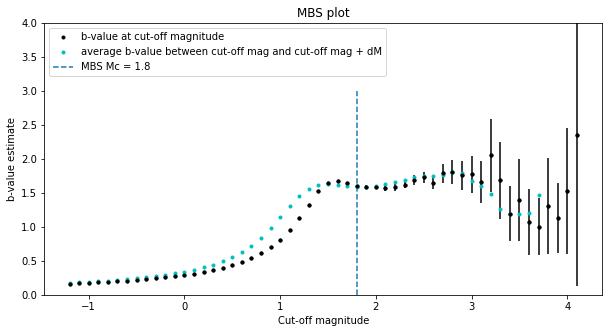

In [16]:
# Plot of MBS estimates (completeness magnitude is first abs(b_avg - b) that's within b-value uncertainty)

cat_mbs = get_mbs(mag = catalog['mw'], mbin = 0.1) # MBS completeness magnitude

plt.plot(cat_mbs[1], cat_mbs[2], '.', color='k', label="b-value at cut-off magnitude") # Black dots are b-value estimates for each cut-off magnitude
plt.errorbar(cat_mbs[1], cat_mbs[2], yerr=cat_mbs[4], fmt='.', color='k')
plt.plot(cat_mbs[1], cat_mbs[3], '.', color="c", label="average b-value between cut-off mag and cut-off mag + dM") # Cyan dots are average b-value over next few magnitude bins
plt.vlines(cat_mbs[0], ymin=0, ymax=3, linestyles='dashed', label="MBS Mc = " + str(round(cat_mbs[0], 1)))
plt.legend(loc='upper left')
plt.ylim(0, 4)
plt.xlabel('Cut-off magnitude')
plt.ylabel('b-value estimate')
plt.title('MBS plot')
plt.show()

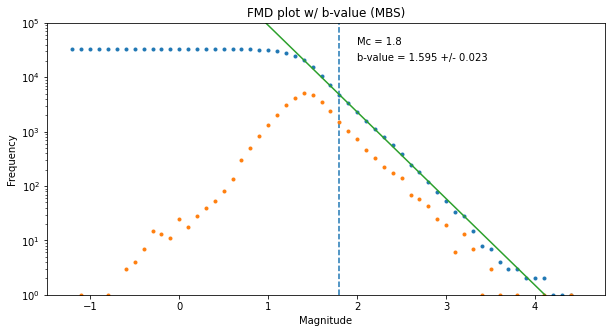

In [17]:
# FMD plot using MBS completeness magnitude for b-value:

cat_mc = cat_mbs[0] # GFT completeness magnitude
cat_a, cat_b, cat_aki_unc, cat_shibolt_unc = b_est(mag = catalog['mw'], mbin = 0.1, mc = cat_mc)

plt.plot(cat_mi, cat_cumnbmag, '.')
plt.plot(cat_mi, cat_nbmag, '.')
plt.plot(cat_mi, (10**(cat_a - (cat_b * cat_mi))))

plt.vlines(cat_mc, ymin=1, ymax=10**math.ceil(math.log10(catalog.shape[0])), linestyles='dashed')

plt.yscale('log')
plt.ylim(1, 10**math.ceil(math.log10(catalog.shape[0])))
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.title('FMD plot w/ b-value (MBS)')
plt.text(x=2, y=4e4, s="Mc = " + str(round(cat_mc, 1)))
plt.text(x=2, y=2e4, s="b-value = " + str(round(cat_b, 3)) + " +/- " + str(round(cat_shibolt_unc, 3)))
plt.show()


#### References

Aki, K. (1965). Maximum likelihood estimate of b in the formula log N=a-bM and its confidence limits, Bull. Earthq.
Res. Inst., Univ. Tokyo, 43, 237–239

Bender, B. (1983). Maximum likelihood estimation of b values for magnitude grouped data, BSSA, 73(3), 931-851

Cao, A. M., & Gao, S. S. (2002). Temporal variations of seismic b-values beneath northeastern Japan island arc,
GRL, 29, doi:10.1029/2001GL013775

Marzocchi, W., & Sandri, L. (2003). A review and new insights on the estimation of the b-value and its uncertainty, Annals of Geophysics, 46(6), 1271-1282

Mignan, A., & Woessner, J. (2012). Estimating the magnitude of completeness for earthquake catalogs, CORSSA (url: http://www.corssa.org/export/sites/corssa/.galleries/articles-pdf/Mignan-Woessner-2012-CORSSA-Magnitude-of-completeness.pdf_2063069299.pdf)

Naylor, M., Orfanogiannaki, K., & Harte, D. (2010). Exploratory Data Analysis: Magnitude, Space, and Time, CORSSA (url: http://www.corssa.org/export/sites/corssa/.galleries/articles-pdf/Naylor-et-al-2010-CORSSA-Exploratory-data-analysis.pdf_2063069299.pdf)

Shi, Y., & Bolt, B. A. (1982). The standard error of the magnitude-frequency b value, BSSA, 72(5), 1677-1687

Wiemer, S., & Wyss, M. (2000). Minimum magnitude of complete reporting in earthquake catalogs: examples from
Alaska, the western United States, and Japan, BSSA, 90, 859–869.